In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer, KNNImputer
import datetime as dt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_validate
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc, roc_auc_score
import datetime as dt
import eli5

# Boosting and Bagging 

This notebook intends to assess the accuracy of bagging and boosting methods.

Here you will find three different sections. 

### Section A - Data Uploading & Train-Test Splits
### Section B - Bagging Estimation
### Section C - Boosting Estimation
### Section D - Comparing the Different Equations

### Section A - Data Uplaing & Train-Test Splits

We will be working mainly with the yearly dataset and setting the framework for conducting all the models. 

In [36]:
#Import yearly dataset
data_annual = pd.read_csv("/Users/andytheo/Desktop/Harvard/Fall 2022/CS 109/Final Project/horn_panel_annual.csv")

#Remove infinity columns
data_annual.replace([np.inf, -np.inf], np.nan, inplace=True)
data_annual = data_annual.dropna()

In [39]:
data_annual.groupby('dis2_code')['violent_incident'].sum()[data_annual]

dis2_code
DJ0101    1
DJ0102    4
DJ0201    3
DJ0202    3
DJ0203    0
         ..
UG4131    6
UG4132    4
UG4133    8
UG4134    1
UG4135    2
Name: violent_incident, Length: 711, dtype: int64

In [7]:

#Dropping the columns that are not necessary for our analysis. 
#Flood Area is a linear combination of Flooding, therefor it is dropped
dropped_cols = ['dis2_code', 'flood_area_missing', 'demonstration', 'flood_area', 'Year']


random_state = 42

#Splitting our dataset into train and test
data_train, data_test = train_test_split(data_annual, random_state = random_state, train_size = 0.8)
data_train = data_train.drop(dropped_cols, axis =1)
data_test = data_test.drop(dropped_cols, axis =1)

X_train = data_train.drop('violent_incident', axis =1)
X_test = data_test.drop('violent_incident', axis =1)
y_train = data_train['violent_incident']
y_test = data_test['violent_incident']

In [8]:
#Test to see whether your dataset is valid
X_train.head()

,drought,flooding,temperature,rainfall,log_pop,flooding_missing,hief,log_gdp,hdi,dis0_name_Eritrea,dis0_name_Kenya,dis0_name_Somalia,dis0_name_South Sudan,dis0_name_Sudan,dis0_name_Uganda
11734,-0.111478,0.000000,34.226749,10.536215,12.697011,1.0,0.746000,8.085166,0.441,0.0,0.0,0.0,0.0,1.0,0.0
14214,-0.524467,0.000000,26.490996,85.282708,11.945901,1.0,0.747000,7.880584,0.424,0.0,0.0,0.0,1.0,0.0,0.0
10134,-0.387149,0.166667,23.633284,52.299815,12.536198,0.0,0.854857,8.118994,0.558,0.0,1.0,0.0,0.0,0.0,0.0
8732,-0.602434,0.166667,23.674167,165.093355,12.267308,0.0,0.854686,8.211494,0.561,0.0,1.0,0.0,0.0,0.0,0.0
3322,-0.526074,0.000000,23.663776,114.103924,11.473316,1.0,0.784000,6.935795,0.412,0.0,0.0,0.0,0.0,0.0,0.0


### Section B - Bagging Estimation

In [9]:
#Split the train for validation
data_train80, data_val = train_test_split(data_train, random_state = random_state, train_size = 0.8)

X_train80 = data_train80.drop('violent_incident', axis =1)
X_val = data_val.drop('violent_incident', axis =1)
y_train80 = data_train80['violent_incident']
y_val = data_val['violent_incident']

In [10]:
#Creating functions to extract predictions for the bagged models and the OOB error

def get_prediction(df):
    return np.mean(df, axis=1)>0.5

def get_oob_prediction(preds, oob_counts):
    oob_idx = oob_counts > 0
    oob_vote = np.sum(preds[oob_idx], axis=1)/oob_counts[oob_idx]
    return oob_vote>0.5

In [ ]:
#Setting the cross validation ro obtain the right amount of tree depth and minimize the instance of overfitting. 

n_trees = 100

training_accuracies_cv = []
val_accuracies_cv = []

depths = np.arange(4, 100, 2)

for i in depths:
#Setting The Decision Tree Classifier
    model = DecisionTreeClassifier(max_depth=i)
#Because we are dealing with classification, we will obtain the majority voting of every row


#Initializing variables
    predictions_train80 = np.zeros(shape = (data_train80.shape[0], n_trees))
    predictions_val  = np.zeros(shape = (data_val.shape[0],  n_trees))

    predictions_oob = np.zeros(shape = (data_train80.shape[0], n_trees))
    oob_samples_count = np.zeros(shape = (data_train80.shape[0], )) # how many times a sample is in oob

    oob_accuracies = []
#Conduct bootstraping iterations
    for i in range(n_trees):
        temp = data_train80.sample(frac=1, replace = True)
        boot_y = temp['violent_incident']
        boot_X = temp.drop(['violent_incident'], axis=1)
    
    # Train a decision tree
        model.fit(boot_X, boot_y)  
        predictions_train80[:,i] = model.predict(X_train80) 
        predictions_val[:,i] = model.predict(X_val)
    
        # Get OOB samples
        oob_mask = ~np.isin(data_train80.index, temp.index)
        oob_temp = data_train80[oob_mask]
        X_oob = oob_temp.drop(['violent_incident'], axis=1)
        y_oob = oob_temp['violent_incident']
        oob_p = model.predict(X_oob)
        predictions_oob[oob_mask, i] = oob_p # Update prediction results of this tree
        oob_samples_count[oob_mask] += 1 # Increase the count of this sample being OOB
    
    training_accuracies_cv.append(accuracy_score(y_train80, get_prediction(predictions_train80)))
    val_accuracies_cv.append(accuracy_score(y_val, get_prediction(predictions_val)))

In [ ]:
#Plotting the CV errors

plt.plot(depths, val_accuracies_cv, label = "Validation")
plt.plot(depths, training_accuracies_cv, label = "Training")
plt.legend()
plt.ylabel("Accuracy Score")
plt.xlabel("Maximum Depth Condition")
plt.title("Finding the optimal max depth with 100 Bootstrapped Samples")

In [ ]:
best_depth = depths[np.argmax(val_accuracies_cv)]
print("The best depth to be used for bagging is ", best_depth)

In [14]:
#Using the best depth for the our bagging estimators. 
best_depth = 32
#Setting The Decision Tree Classifier
model = DecisionTreeClassifier(max_depth=best_depth)
#Because we are dealing with classification, we will obtain the majority voting of every row


#Initializing variables
predictions_train = np.zeros( shape = (data_train.shape[0], n_trees))
predictions_test  = np.zeros( shape = (data_test.shape[0],  n_trees))

predictions_oob = np.zeros(shape = (data_train.shape[0], n_trees))
oob_samples_count = np.zeros(shape = (data_train.shape[0], )) # how many times a sample is in oob

oob_accuracies = []
#Conduct bootstraping iterations
for i in range(n_trees):
    temp = data_train.sample(frac=1, replace=True)
    boot_y = temp['violent_incident']
    boot_X = temp.drop(['violent_incident'], axis=1)
    
    # Train a decision tree
    model.fit(boot_X, boot_y)  
    predictions_train[:,i] = model.predict(X_train)   
    predictions_test[:,i] = model.predict(X_test)
    
    # Get OOB samples
    oob_mask = ~np.isin(data_train.index, temp.index)
    oob_temp = data_train[oob_mask]
    X_oob = oob_temp.drop(['violent_incident'], axis=1)
    y_oob = oob_temp['violent_incident']
    #Predict the OOB Samples
    oob_p = model.predict(X_oob)
    #Checking if the dataset is correct
    predictions_oob[oob_mask, i] = oob_p # Update prediction results of this tree
    oob_samples_count[oob_mask] += 1 # Increase the count of this sample being OOB

In [15]:
#Obtaining the accuracy scores for train, test and OOB
acc_bagging_training = 100*accuracy_score(y_train, get_prediction(predictions_train))
acc_bagging_testing  = 100*accuracy_score(y_test, get_prediction(predictions_test))
acc_bagging_oob = 100*accuracy_score(y_train, get_oob_prediction(predictions_oob, oob_samples_count))

In [16]:
print("Bagging: \tAccuracy, Training Set \t: {:0.2f}%".format(acc_bagging_training))
print("Bagging: \tAccuracy, Test Set \t: {:0.2f}%".format(acc_bagging_testing))
print("Bagging: \tAccuracy, OOB Set \t: {:0.2f}%".format(acc_bagging_oob))

Bagging: 	Accuracy, Training Set 	: 100.00%
Bagging: 	Accuracy, Test Set 	: 80.13%
Bagging: 	Accuracy, OOB Set 	: 80.16%


In [17]:
#Extracting the False Negative Rate and False Positive Rate

y_hat_bagging = model.predict_proba(X_test)

conf_matrix_bagging = pd.crosstab(np.array(y_test), model.predict(X_test), margins=True, rownames=['Actual'], colnames=['Predicted'])

fpr_bagging = conf_matrix_bagging[1][0]/conf_matrix_bagging['All'][0]*100
fnr_bagging = conf_matrix_bagging[0][1]/conf_matrix_bagging['All'][1]*100


print("Bagging: \tFalse Positive Rate, Training Set \t: {:0.2f}%".format(fpr_bagging))
print("Bagging: \tFalse Negative Rate, Test Set \t: {:0.2f}%".format(fnr_bagging))

Bagging: 	False Positive Rate, Training Set 	: 17.80%
Bagging: 	False Negative Rate, Test Set 	: 50.71%


### Section C - Boosting Estimation

In [ ]:
#Cross validation for the AdaBoost Classifier using 27 different trees
learning_rate = 0.3
n_estimators = np.arange(1, 800, 30)

#Setting a depth of 2
depth = 2

val_scores = []
train_scores = []

for i in n_estimators: 
    ab = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth = depth), n_estimators = i, 
                           learning_rate = learning_rate, 
                            random_state = random_state, algorithm = 'SAMME.R')
    
    cross_val = cross_val_score(ab, X_train, y_train, cv = 10, 
                               scoring = 'accuracy')
    
    val_scores.append(np.mean(cross_val))  
    
best_estimators = n_estimators[np.argmax(val_scores)]

In [ ]:
#Plotting the cross-validated errors for boosting
plt.plot(n_estimators, val_scores, label = 'Train')
plt.xlabel("Estimators")
plt.ylabel("Accuracy")
plt.title("Cross Validation Results for Boosting")

print("The best number of estimators is", best_estimators)

In [22]:
#Given how much time Boosting needs to run, we are hard-coding the estimator here in case we need to run this again
best_estimators = 181
best_boost = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth = depth), 
                                n_estimators = best_estimators, 
                               learning_rate = learning_rate, 
                               random_state = random_state, algorithm = 'SAMME.R').fit(X_train, y_train)

In [23]:
train_score = best_boost.score(X_train, y_train)
test_score = best_boost.score(X_test, y_test)

print("The train score is", train_score, 'and test score is', test_score)

The train score is 0.8102736584620088 and test score is 0.7905839192907368


In [25]:
predictions_test_boosting = best_boost.predict(X_test)

In [26]:
conf_matrix_boosting = pd.crosstab(np.array(y_test), best_boost.predict(X_test), margins=True, rownames=['Actual'], colnames=['Predicted'])


fpr_boosting = conf_matrix_boosting[1][0]/conf_matrix_boosting['All'][0]*100
fnr_boosting = conf_matrix_boosting[0][1]/conf_matrix_boosting['All'][1]*100


In [27]:

print("The false positive rate for Boosting is", fpr_boosting, "and false negative rate is", fnr_boosting)
conf_matrix_boosting

The false positive rate for Boosting is 5.508474576271186 and false negative rate is 60.922063666300765


Predicted,0,1,All
Actual,,,
0,2230,130,2360
1,555,356,911
All,2785,486,3271


In [28]:
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(best_boost, random_state= random_state, n_iter=10).fit(X_test, y_test)
eli5.show_weights(perm, feature_names=X_train.columns.tolist())

Weight,Feature
0.0496 ± 0.0083,log_pop
0.0469 ± 0.0089,rainfall
0.0412 ± 0.0091,temperature
0.0389 ± 0.0053,hief
0.0178 ± 0.0070,log_gdp
0.0171 ± 0.0092,drought
0.0099 ± 0.0045,hdi
0.0095 ± 0.0034,dis0_name_South Sudan
0.0056 ± 0.0032,dis0_name_Sudan
0.0030 ± 0.0025,flooding


Let us re-run the model using the variables that the model classified as important. 

In [29]:
variables_important = ['log_pop', 'rainfall', 'temperature', 
                       'hief', 'log_gdp', 'drought', 'hdi', 'dis0_name_South Sudan', 
                      'dis0_name_Sudan']

X_train_imp = X_train[variables_important]
X_test_imp = X_test[variables_important]

In [30]:
#Re run the boosting algorithm 
boost_imp = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth = depth), 
                                n_estimators = best_estimators, 
                               learning_rate = learning_rate, 
                               random_state = random_state, algorithm = 'SAMME.R').fit(X_train_imp, y_train)

In [31]:
train_score = boost_imp.score(X_train_imp, y_train)
test_score = boost_imp.score(X_test_imp, y_test)

print("The train score is", train_score, 'and test score is', test_score)

predictions_test = boost_imp.predict(X_test_imp)
conf_matrix = confusion_matrix(y_test, predictions_test)

fpr= confusion_matrix(y_test, predictions_test)[0, 1]/ (confusion_matrix(y_test, predictions_test)[0, 1] + confusion_matrix(y_test, predictions_test)[0, 0])

fnr= confusion_matrix(y_test, predictions_test)[1, 0]/ (confusion_matrix(y_test, predictions_test)[1, 1] + confusion_matrix(y_test, predictions_test)[1, 0])
#After dropping the most important variables, the boosting algorithm performs worse. 

The train score is 0.8067573765479285 and test score is 0.789972485478447


In [32]:
print("The false positive rate for Boosting is", fpr, "and false negative rate is", fnr)

The false positive rate for Boosting is 0.051694915254237285 and false negative rate is 0.6201975850713501


In [33]:
#Comparing the ROC curves for both bagging and boosting

model.predict_proba(X_test)
fpr_bagging, tpr_bagging, thresholds = roc_curve(y_test, y_hat_bagging[:,1])

fpr_boosting, tpr_boosting, thresholds = roc_curve(y_test, best_boost.predict_proba(X_test)[:,1])
fpr_imp_boosting, tpr_imp_boosting, thresholds = roc_curve(y_test, boost_imp.predict_proba(X_test_imp)[:,1])


### Comparing between the two models 

In [34]:
auc_bagging = auc(fpr_bagging, tpr_bagging)
auc_boosting = auc(fpr_boosting, tpr_boosting)
auc_boosting_imp = auc(fpr_imp_boosting, tpr_imp_boosting)

print(auc_bagging, auc_boosting, auc_boosting_imp)

0.657449440919831 0.8030233120616198 0.8026272581815475


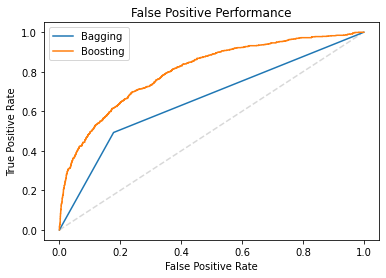

<Figure size 432x288 with 0 Axes>

In [35]:
x=np.arange(0,100)/100

#Plotting the ROC for both models. 

plt.plot(x,x,'--',color="gray",alpha=0.3)
plt.plot(fpr_bagging,tpr_bagging, label = "Bagging")
plt.plot(fpr_boosting, tpr_boosting, label = "Boosting")
plt.legend()
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.title("False Positive Performance")
plt.show()

plt.savefig('roc_boosting_bagging.png')